In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from bs4 import BeautifulSoup


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

py.init_notebook_mode(connected=True)

In [3]:
df = pd.read_csv('mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/50)
df['variance_of_word_counts'] = df['posts'].apply(lambda x: var_row(x))
df.head()

,type,posts,words_per_comment,variance_of_word_counts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,23,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,16,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,19,196.4576


In [5]:
df.groupby('type').agg({'type':'count'})

,type
type,
ENFJ,190
ENFP,675
ENTJ,231
ENTP,685
ESFJ,42
ESFP,48
ESTJ,39
ESTP,89
INFJ,1470


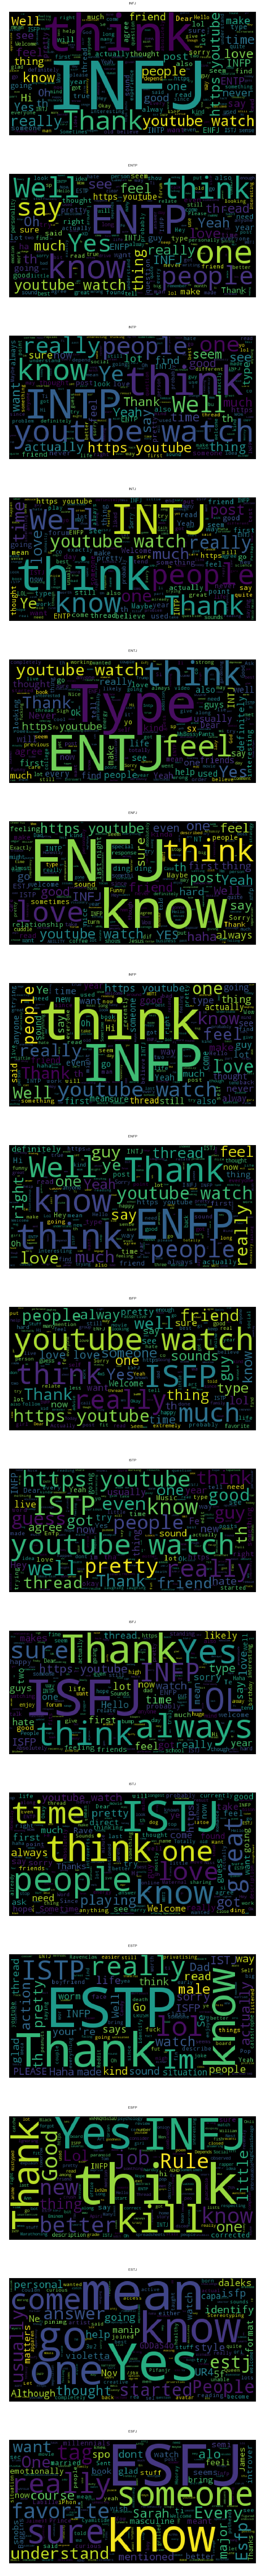

In [6]:
from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS

fig, ax = plt.subplots(len(df['type'].unique()), sharex=True, figsize=(15,10*len(df['type'].unique())))

k = 0
for i in df['type'].unique():
    df_4 = df[df['type'] == i]
    wordcloud = WordCloud().generate(df_4['posts'].to_string())
    ax[k].imshow(wordcloud)
    ax[k].set_title(i)
    ax[k].axis("off")
    k+=1

In [18]:
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    return text
df['clean_posts'] = df['posts'].apply(cleanText)

In [26]:
del df['posts']
df.head()

,type,words_per_comment,variance_of_word_counts,clean_posts
0,INFJ,11,135.2900,'<URL> <URL> enfp and intj moments <URL> spo...
1,ENTP,23,187.4756,'I'm finding the lack of me in these posts ver...
2,INTP,16,180.6900,"'Good one _____ <URL> Of course, to which I..."
3,INTJ,21,181.8324,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,19,196.4576,'You're fired. That's another silly misconcept...


In [7]:
df.to_csv("clean.csv", encoding='utf-8', index=True)

In [8]:
clean = pd.read_csv('clean.csv')
clean.head()

,Unnamed: 0,type,posts,words_per_comment,variance_of_word_counts
0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11,135.2900
1,1,ENTP,'I'm finding the lack of me in these posts ver...,23,187.4756
2,2,INTP,'Good one _____ https://www.youtube.com/wat...,16,180.6900
3,3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21,181.8324
4,4,ENTJ,'You're fired.|||That's another silly misconce...,19,196.4576


In [16]:
# Post Cleaning
import nltk
nltk.download('stopwords')
cachedStopWords = stopwords.words("english")

# Label encoder
from sklearn.preprocessing import LabelEncoder

unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
lab_encoder = LabelEncoder().fit(unique_type_list)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/FeiYang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
##### Compute list of subject with Type | list of comments 
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')

# Lemmatize
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

def pre_process_data(data, remove_stop_words=True):

    list_personality = []
    list_posts = []
    len_data = len(data)
    i=0
    
    for row in data.iterrows():
        i+=1
        if i % 500 == 0:
            print("%s | %s rows" % (i, len_data))

        ##### Remove and clean comments
        posts = row[1].posts
        temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'link', posts)
        temp = re.sub("[^a-zA-Z]", " ", temp)
        temp = re.sub(' +', ' ', temp).lower()
        if remove_stop_words:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in cachedStopWords])
        else:
            temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])

        type_labelized = lab_encoder.transform([row[1].type])[0]
        list_personality.append(type_labelized)
        list_posts.append(temp)

    #del data
    list_posts = np.array(list_posts)
    list_personality = np.array(list_personality)
    return list_posts, list_personality

list_posts, list_personality = pre_process_data(clean, remove_stop_words=True)

[nltk_data] Downloading package wordnet to /Users/FeiYang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
500 | 8675 rows
1000 | 8675 rows
1500 | 8675 rows
2000 | 8675 rows
2500 | 8675 rows
3000 | 8675 rows
3500 | 8675 rows
4000 | 8675 rows
4500 | 8675 rows
5000 | 8675 rows
5500 | 8675 rows
6000 | 8675 rows
6500 | 8675 rows
7000 | 8675 rows
7500 | 8675 rows
8000 | 8675 rows
8500 | 8675 rows


In [20]:
print(list_posts[1:16])

[ u' finding lack post alarming sex boring position often example girlfriend currently environment creatively use cowgirl missionary enough giving new meaning game theory hello entp grin take converse flirting acknowledge presence return word smooth wordplay cheeky grin lack balance hand eye coordination real iq test score internet iq test funny score higher like former response thread mention believe iq test banish know entp vanish site year half return find people still commenting post liking idea thought know entp link link think thing sometimes go old sherlock holmes quote perhaps man special knowledge special power like rather encourages seek complex cheshirewolf tumblr com post really never thought e j p real function judge use use ne ti dominates fe emotion rarely si also use ni due strength know though ingenious saying really want try see happens playing first person shooter back drive around want see look rock paper one best make lol guy lucky really high tumblr system hear ne